<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="33%"/>
  </p>
  
# **Trabajo Práctico 1: Reservas de Hotel**
### **Checkpoint**: 2
### **Grupo**: 11 - Los Pandas
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo
### **Integrantes**:
### 103456 - Labollita, Francisco
### 102312 - Mundani Vegega, Ezequiel
###  97263 - Otegui, Matías Iñaki

## Clasificación - Entrenamiento y Predicción

### Carga inicial de dependencias y datos

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calendar
import dtreeviz
import warnings

#modelos y métricas
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score#, precision_recall_curve, roc_curve,
from sklearn.metrics import confusion_matrix, classification_report

#preprocesamiento
from sklearn.preprocessing import MinMaxScaler

# Aclaración:
# Hay un warning que puede llegar a aparecer que es debido a una actualización interna de Seaborn que será deprecada, para solucionarlo hay que modificar el código de python
# directamente (lo cual no es una buena práctica).
# La función en concreto se va a seguir utilizando, por lo que no afecta a nuestro código en sí, si no al comportamiento interno de dicha función.
# Se propone ignorar dicho warninig, ya que se solucionará en la próxima versión de Python
# En el siguiente enlace se puede encontrar más información:
# https://github.com/ultralytics/ultralytics/issues/4729
# https://github.com/mwaskom/seaborn/issues/3462
#
# se puede ignorar descomentando las siguientes líneas

warnings.filterwarnings('ignore', 'is_categorical_dtype is deprecated')
warnings.filterwarnings("ignore", "use_inf_as_na")

# o bien otra solución (más elegante), es obtener dicha actualización corriendo esta línea:
# pip install -U ultralytics

In [2]:
hotels_df = pd.read_csv('hotels_train.csv')
hotels_df_backup = hotels_df.copy()
hotels_df_mod = hotels_df.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)

hotels_df_mod = hotels_df_mod.dropna(subset=['country', 'distribution_channel', 'market_segment'])

hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['required_car_parking_spaces'] = hotels_df_mod['required_car_parking_spaces'].astype(bool)

hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['days_in_waiting_list'] = hotels_df_mod['days_in_waiting_list'].astype(bool)

hotels_df_mod['babies'] = hotels_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['babies'] = hotels_df_mod['babies'].astype(bool)

hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_cancellations'] = hotels_df_mod['previous_cancellations'].astype(bool)

hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['total_of_special_requests'] = hotels_df_mod['total_of_special_requests'].astype(bool)

hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['previous_bookings_not_canceled'] = hotels_df_mod['previous_bookings_not_canceled'].astype(bool)

hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
hotels_df_mod['booking_changes'] = hotels_df_mod['booking_changes'].astype(bool)
hotels_df_mod = hotels_df_mod.drop(hotels_df_mod[hotels_df_mod['adults'] > 4].index)

#MIO
hotels_df_mod['agent'] = hotels_df_mod['agent'].astype(str)
#FIN

# renombrar columna del dataframe de reserved_room_type a room_type_match
hotels_df_mod = hotels_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

hotels_df_mod.loc[hotels_df_mod['room_type_match'] == hotels_df_mod['assigned_room_type'], 'room_type_match'] = True
hotels_df_mod.loc[hotels_df_mod['room_type_match'] != hotels_df_mod['assigned_room_type'], 'room_type_match'] = False

hotels_df_mod['room_type_match'] = hotels_df_mod['room_type_match'].astype(bool)

In [3]:
hotels_df_mod.to_csv('hotels_df_modified.csv', index=False)

In [4]:
hotels_df = pd.read_csv('hotels_df_modified.csv')
hotels_df_backup = hotels_df.copy()

In [5]:
#One hot encoding para variables categoricas
hotels_df_x = pd.get_dummies(hotels_df, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent" ], drop_first=True)

#Creo un dataset con los features que voy a usar para clasificar
hotels_df_x = hotels_df_x.drop(['is_canceled'], axis='columns')

hotels_df_x = hotels_df_x.reindex(sorted(hotels_df_x.columns), axis=1)

#Creo un dataset con la variable target
hotels_df_y = hotels_df['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(hotels_df_x,
                                                    hotels_df_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

#Creo un clasificador
tree_model = tree.DecisionTreeClassifier(max_depth = 10)

#Entreno el modelo
model = tree_model.fit(X = x_train, y = y_train)

# tree_model = tree.DecisionTreeClassifier(criterion="entropy",
#                                          max_depth = 20,
#                                          min_samples_leaf=10)
# model = tree_model.fit(X = x_train, y = y_train)

In [6]:
#Realizamos una predicción sobre el set de test
y_pred = model.predict(x_test)
#Valores Predichos
y_pred

#Valores Reales
y_test.values

#Probemos verlos juntos en un DataFrame
ds_resultados=pd.DataFrame(zip(y_test,y_pred),columns=['test','pred'])
ds_resultados.head(10)

test  pred
0     1     0
1     0     0
2     1     1
3     1     1
4     0     0
5     1     1
6     1     1
7     0     0
8     1     0
9     1     1

In [7]:
x_test.head(10)

adults  agent_10.0  agent_103.0  agent_104.0  agent_105.0  agent_106.0  \
14664       1       False        False        False        False        False   
51708       2       False        False        False        False        False   
45321       2       False        False        False        False        False   
45432       2       False        False        False        False        False   
51620       2       False        False        False        False        False   
51748       2       False        False        False        False        False   
45667       2       False        False        False        False        False   
32876       2       False        False        False        False        False   
54493       2       False        False        False        False        False   
10607       2       False        False        False        False        False   

       agent_107.0  agent_11.0  agent_110.0  agent_111.0  ...  \
14664        False       False        False        False  ...   
51708        False       False        False        False  ...   
45321        False       False        False        False  ...   
45432        False       False        False        False  ...   
51620        False       False        False        False  ...   
51748        False       False        False        False  ...   
45667        False       False        False        False  ...   
32876        False       False        False        False  ...   
54493        False       False        False        False  ...   
10607        False       False        False        False  ...   

       market_segment_Undefined  meal_FB  meal_HB  meal_SC  meal_Undefined  \
14664                     False    False    False    False           False   
51708                     False    False    False    False           False   
45321                     False    False     True    False           False   
45432                     False    False    False    False           False   
51620                     False    False    False    False           False   
51748                     False    False    False    False           False   
45667                     False    False    False    False           False   
32876                     False    False    False    False           False   
54493                     False    False    False    False           False   
10607                     False    False     True    False           False   

       previous_bookings_not_canceled  previous_cancellations  \
14664                           False                   False   
51708                           False                   False   
45321                           False                   False   
45432                           False                    True   
51620                           False                   False   
51748                           False                   False   
45667                           False                   False   
32876                           False                   False   
54493                           False                   False   
10607                           False                   False   

       required_car_parking_spaces  room_type_match  total_of_special_requests  
14664                        False            False                      False  
51708                        False            False                      False  
45321                        False            False                      False  
45432                        False            False                      False  
51620                        False            False                       True  
51748                        False            False                      False  
45667                        False            False                      False  
32876                        False            False                       True  
54493                        False            False                       True  
10607         

Text(50.722222222222214, 0.5, 'True')

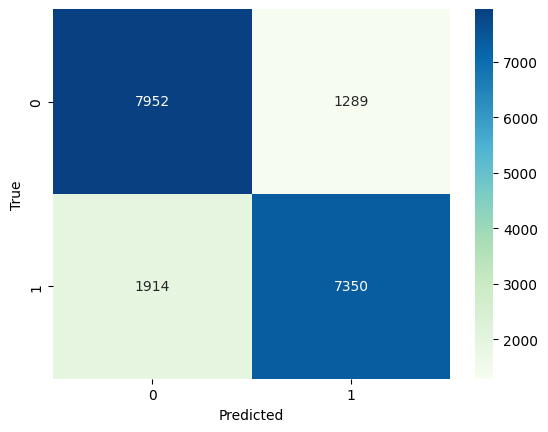

In [8]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [9]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
f1=f1_score(y_test,y_pred,)
precision=precision_score(y_test,y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

print(classification_report(y_test,y_pred))

Accuracy: 0.8269116455012159
Recall: 0.7933937823834197
Precision: 0.8507929158467415
f1 score: 0.821091437189298
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      9241
           1       0.85      0.79      0.82      9264

    accuracy                           0.83     18505
   macro avg       0.83      0.83      0.83     18505
weighted avg       0.83      0.83      0.83     18505



In [10]:
model.classes_

array([0, 1], dtype=int64)

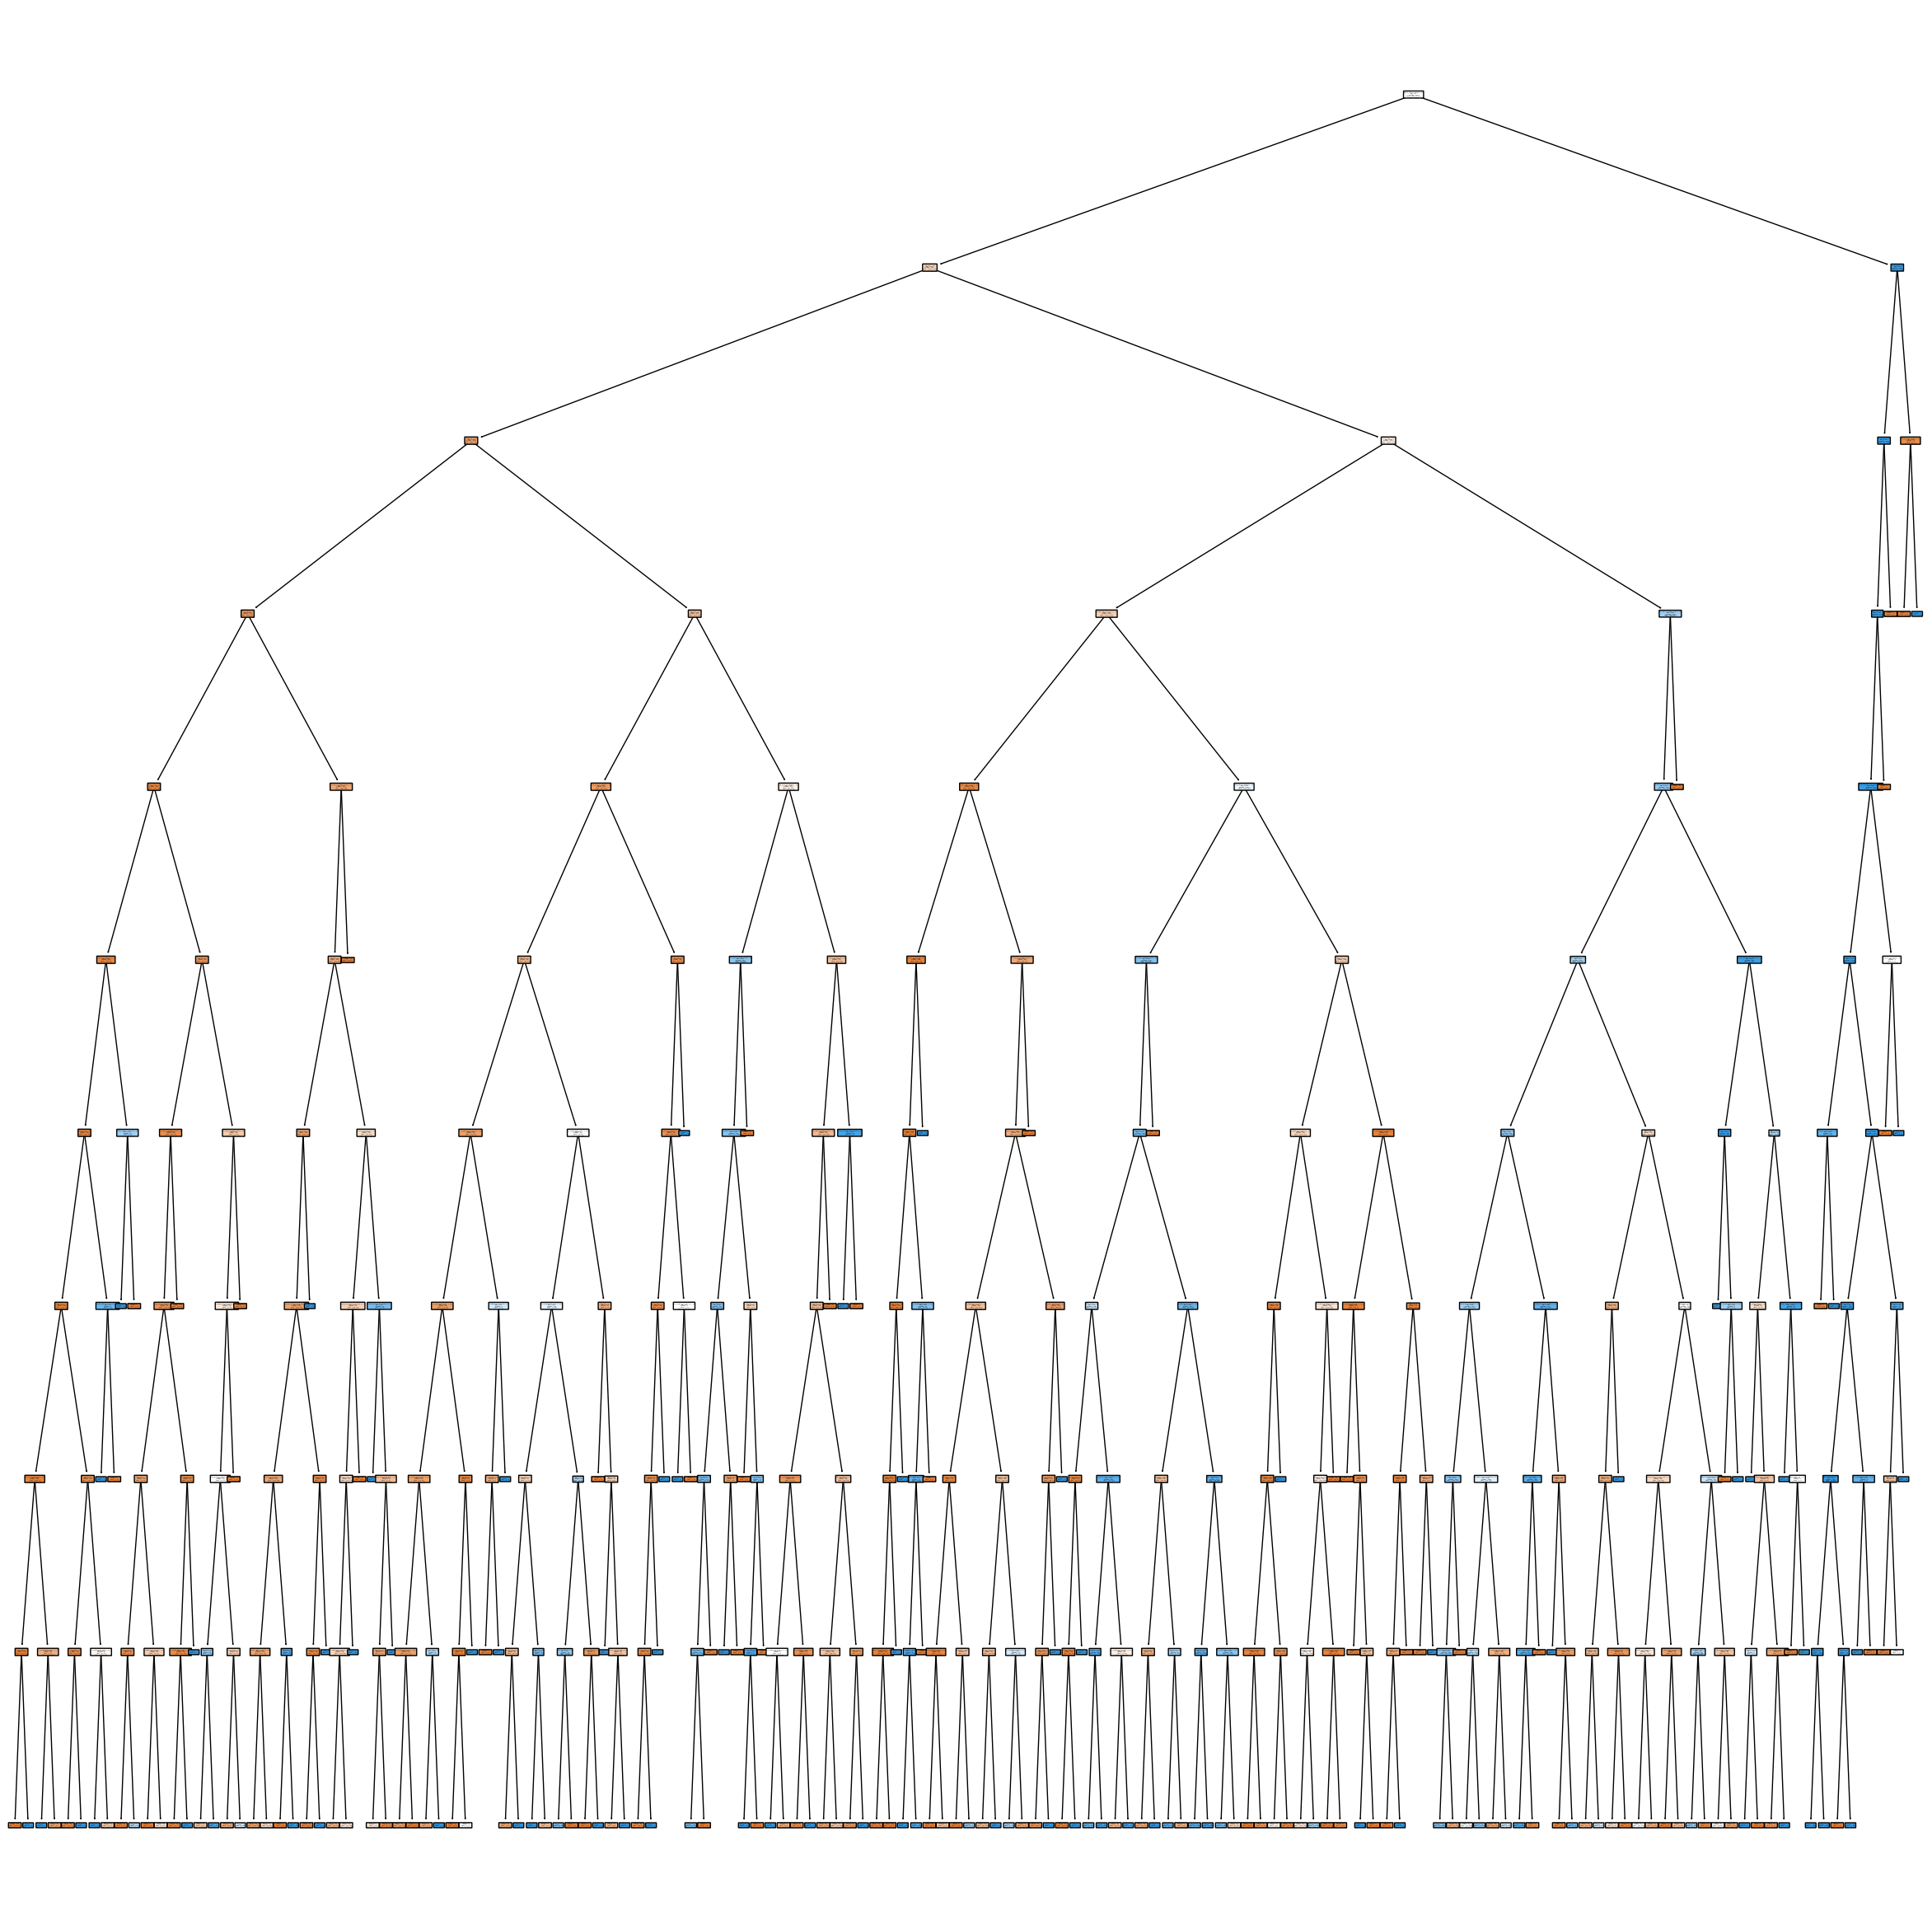

In [11]:
plt.figure(figsize=(30,30))

tree_plot_completo=tree.plot_tree(model,
                                 feature_names=hotels_df_x.columns.to_list(),
                                 filled=True,
                                 rounded=True,
                                 class_names=['Not canceled','Canceled']) #model.classes_
plt.show(tree_plot_completo)

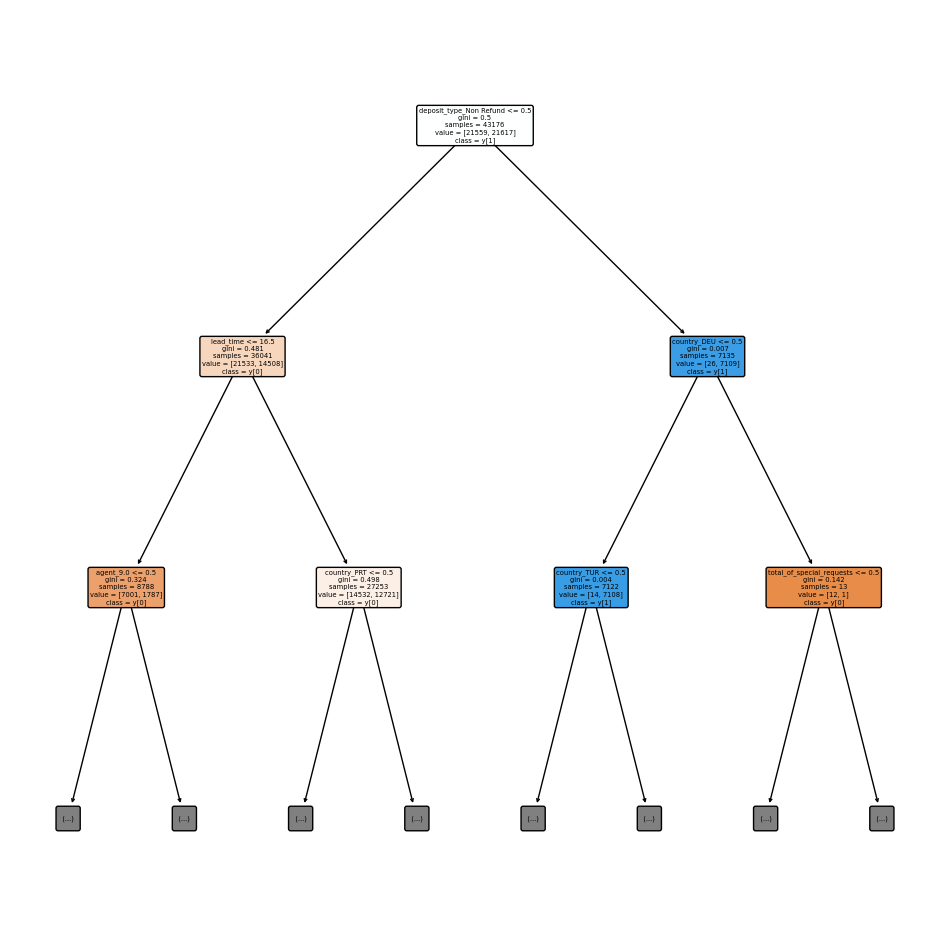

In [12]:
plt.figure(figsize=(12,12))

tree_plot=tree.plot_tree(model,
                         max_depth=2,
                         feature_names=hotels_df_x.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)

In [13]:
viz_model = dtreeviz.model(model,
                            X_train=hotels_df_x, y_train=hotels_df_y,
                            feature_names=hotels_df_x.columns.to_list(),
                            target_name='Canceled',
                            class_names=['Not canceled','Canceled'])

v = viz_model.view(scale = 1.5, title = 'Arbol de decisión. Modelo inicial')
display(v)

c:\Users\franc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


## Se predice hotels_test

In [14]:
test_df = pd.read_csv('hotels_test.csv')

test_df_mod = test_df.copy()

test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].apply(lambda x: True if x >= 1 else False)
test_df_mod['required_car_parking_spaces'] = test_df_mod['required_car_parking_spaces'].astype(bool)

test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].apply(lambda x: True if x >= 1 else False)
test_df_mod['days_in_waiting_list'] = test_df_mod['days_in_waiting_list'].astype(bool)

test_df_mod['babies'] = test_df_mod['babies'].apply(lambda x: True if x >= 1 else False)
test_df_mod['babies'] = test_df_mod['babies'].astype(bool)

test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_cancellations'] = test_df_mod['previous_cancellations'].astype(bool)

test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].apply(lambda x: True if x >= 1 else False)
test_df_mod['total_of_special_requests'] = test_df_mod['total_of_special_requests'].astype(bool)

test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].apply(lambda x: True if x >= 1 else False)
test_df_mod['previous_bookings_not_canceled'] = test_df_mod['previous_bookings_not_canceled'].astype(bool)

test_df_mod['booking_changes'] = test_df_mod['booking_changes'].apply(lambda x: True if x >= 1 else False)
test_df_mod['booking_changes'] = test_df_mod['booking_changes'].astype(bool)

# renombrar columna del dataframe de reserved_room_type a room_type_match
test_df_mod = test_df_mod.rename(columns={'reserved_room_type': 'room_type_match'})

test_df_mod.loc[test_df_mod['room_type_match'] == test_df_mod['assigned_room_type'], 'room_type_match'] = True
test_df_mod.loc[test_df_mod['room_type_match'] != test_df_mod['assigned_room_type'], 'room_type_match'] = False

test_df_mod['room_type_match'] = test_df_mod['room_type_match'].astype(bool)

test_df_mod['agent'] = test_df_mod['agent'].astype(str)


id_backup = test_df_mod[['id']].copy()


test_df_mod = test_df_mod.drop(['arrival_date_year', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'children', 'company', 'adr', 'id'], axis=1)
test_df_mod = test_df_mod.drop(['reservation_status_date'], axis='columns')


In [15]:
test_df_mod = pd.get_dummies(test_df_mod, columns=["hotel", "arrival_date_month", "meal", "country", "market_segment", "distribution_channel", "assigned_room_type", "deposit_type", "customer_type", "agent" ], drop_first=True)

In [16]:
#Se crean las columnas que están en el df para entrenar pero no en el df a precedir
for col in hotels_df_x.columns:
    if col not in test_df_mod.columns:
        test_df_mod[col] = False

#Se eliminan las columnas que están en el df para predecir pero no en el df para entrenar
for col in test_df_mod.columns:
    if col not in hotels_df_x.columns:
        test_df_mod = test_df_mod.drop(columns=[col])

test_df_mod = test_df_mod.reindex(sorted(test_df_mod.columns), axis=1)

In [17]:
#Realizamos una predicción sobre el set de test
y_pred = model.predict(test_df_mod)

predictions = pd.DataFrame()

predictions['id'] = id_backup['id'].values
predictions['is_canceled'] = y_pred

predictions.to_csv('entrega.csv', index=False)